# Analyse output from test runs using input4MIPS
see
- https://github.com/COSIMA/access-om2/issues/120
- https://github.com/COSIMA/access-om2/issues/155
- https://github.com/COSIMA/libaccessom2/issues/20
- https://github.com/COSIMA/libaccessom2/issues/25
- https://github.com/COSIMA/libaccessom2/pull/26

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math
from collections import OrderedDict
# import seaborn as sns

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [3]:
# replace contents of exptdata.exptdict
for ekey in list(exptdata.exptdict.keys()):
    del exptdata.exptdict[ekey]

In [4]:
for ekey in ['1deg_jra55_iaf_control', #'1deg_jra55_iaf_test_yearp1', 
             '1deg_jra55_iaf_test_yearp1_qv56', #'1deg_jra55_iaf_test_yearp1_qv56_2',
             '1deg_jra55_iaf_test_yearp1_qv56_3',
             #'1deg_jra55_iaf_test_yearp1_qv56_2_hybrid',
             '1deg_jra55_iaf_test_yearp1_qv56_2_gadi',
             '1deg_jra55_iaf_test_yearp1_qv56_2_gadi_2',
             '1deg_jra55v1p4p0_iaf_test_gadi',
             '1deg_jra55v1p4p0_iaf_test_gadi_2',
             'gadi_test_025deg_jra55_iaf',
             'gadi_test_01deg_jra55_iaf',
             'gadi_ak_dev_test_1deg_jra55_iaf',
             'gadi_ak_dev_test_025deg_jra55_iaf' #,
#              'gadi_ak_dev_test_01deg_jra55_iaf'
            ]:
    if ekey not in exptdata.exptdict:
        print('Adding '+ekey)
        exptdata.exptdict[ekey] = dict()
        e = exptdata.exptdict[ekey]
        if ekey not in ['gadi_test_025deg_jra55_iaf',
             'gadi_test_01deg_jra55_iaf',
             'gadi_ak_dev_test_1deg_jra55_iaf',
             'gadi_ak_dev_test_025deg_jra55_iaf',
             'gadi_ak_dev_test_01deg_jra55_iaf']:
            e['expt'] = 'input4MIPs_testing_'+ekey
            e['model'] = 'access-om2'
        else:
            e['expt'] = ekey
            if ekey.find('_1deg') >= 0:
                e['model'] = 'access-om2'
            elif ekey.find('_025deg') >= 0:
                e['model'] = 'access-om2-025'
            else:
                e['model'] = 'access-om2-01'
        e['exptdir'] = '/g/data/hh5/tmp/cosima/'+e['model']+'/'+e['expt']
        e['desc'] = ekey
        e['time_units'] = None
        e['offset'] = None 

Adding 1deg_jra55_iaf_control
Adding 1deg_jra55_iaf_test_yearp1_qv56
Adding 1deg_jra55_iaf_test_yearp1_qv56_3
Adding 1deg_jra55_iaf_test_yearp1_qv56_2_gadi
Adding 1deg_jra55_iaf_test_yearp1_qv56_2_gadi_2
Adding 1deg_jra55v1p4p0_iaf_test_gadi
Adding 1deg_jra55v1p4p0_iaf_test_gadi_2
Adding gadi_test_025deg_jra55_iaf
Adding gadi_test_01deg_jra55_iaf
Adding gadi_ak_dev_test_1deg_jra55_iaf
Adding gadi_ak_dev_test_025deg_jra55_iaf


In [10]:
expt_dir_list=[e['exptdir'] for e in exptdata.exptdict.values()]

In [11]:
expt_dir_list

['/g/data/hh5/tmp/cosima/access-om2/input4MIPs_testing_1deg_jra55_iaf_control',
 '/g/data/hh5/tmp/cosima/access-om2/input4MIPs_testing_1deg_jra55_iaf_test_yearp1_qv56',
 '/g/data/hh5/tmp/cosima/access-om2/input4MIPs_testing_1deg_jra55_iaf_test_yearp1_qv56_3',
 '/g/data/hh5/tmp/cosima/access-om2/input4MIPs_testing_1deg_jra55_iaf_test_yearp1_qv56_2_gadi',
 '/g/data/hh5/tmp/cosima/access-om2/input4MIPs_testing_1deg_jra55_iaf_test_yearp1_qv56_2_gadi_2',
 '/g/data/hh5/tmp/cosima/access-om2/input4MIPs_testing_1deg_jra55v1p4p0_iaf_test_gadi',
 '/g/data/hh5/tmp/cosima/access-om2/input4MIPs_testing_1deg_jra55v1p4p0_iaf_test_gadi_2',
 '/g/data/hh5/tmp/cosima/access-om2-025/gadi_test_025deg_jra55_iaf',
 '/g/data/hh5/tmp/cosima/access-om2-01/gadi_test_01deg_jra55_iaf',
 '/g/data/hh5/tmp/cosima/access-om2/gadi_ak_dev_test_1deg_jra55_iaf',
 '/g/data/hh5/tmp/cosima/access-om2-025/gadi_ak_dev_test_025deg_jra55_iaf']

In [12]:
cc.build_index(careful=True, expt_dir_list=expt_dir_list)


Indexed 2323 variables found in new files
Saving results in database sqlite:////g/data/hh5/tmp/cosima/access-om2-025/gadi_ak_dev_test_025deg_jra55_iaf/cosima-cookbook.db... 
Indexing complete.


True

In [13]:
exptdata.exptdict

OrderedDict([('1deg_jra55_iaf_control',
              {'expt': 'input4MIPs_testing_1deg_jra55_iaf_control',
               'model': 'access-om2',
               'exptdir': '/g/data/hh5/tmp/cosima/access-om2/input4MIPs_testing_1deg_jra55_iaf_control',
               'desc': '1deg_jra55_iaf_control',
               'time_units': None,
               'offset': None}),
             ('1deg_jra55_iaf_test_yearp1_qv56',
              {'expt': 'input4MIPs_testing_1deg_jra55_iaf_test_yearp1_qv56',
               'model': 'access-om2',
               'exptdir': '/g/data/hh5/tmp/cosima/access-om2/input4MIPs_testing_1deg_jra55_iaf_test_yearp1_qv56',
               'desc': '1deg_jra55_iaf_test_yearp1_qv56',
               'time_units': None,
               'offset': None}),
             ('1deg_jra55_iaf_test_yearp1_qv56_3',
              {'expt': 'input4MIPs_testing_1deg_jra55_iaf_test_yearp1_qv56_3',
               'model': 'access-om2',
               'exptdir': '/g/data/hh5/tmp/cosima/access-om2

In [13]:
figdir = ''
def savefigure(fname):
#     plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
#     plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [14]:
def load_data(variable,ncfile):
    for ekey in exptdata.exptdict.keys():
        e = exptdata.exptdict[ekey]
        if ncfile not in e:
            e[ncfile] = OrderedDict.fromkeys('')
        if variable not in e[ncfile]:
            print(ekey)
            e[ncfile][variable] = cc.get_nc_variable(e['exptdir'],ncfile,
                                    variable,
                                    time_units=e['time_units'],offset=e['offset'])

## checking scalar timeseries

In [30]:
variables = ['temp_global_ave', 'temp_surface_ave', 'salt_surface_ave', 'ke_tot']
# variables = ['temp_global_ave']
for v in variables:
    load_data(v,'ocean_scalar.nc')

1deg_jra55_iaf_control
Using database sqlite:////g/data/hh5/tmp/cosima/access-om2/input4MIPs_testing_1deg_jra55_iaf_control/cosima-cookbook.db
1deg_jra55_iaf_test_yearp1_qv56
Using database sqlite:////g/data/hh5/tmp/cosima/access-om2/input4MIPs_testing_1deg_jra55_iaf_test_yearp1_qv56/cosima-cookbook.db
1deg_jra55_iaf_test_yearp1_qv56_3
Using database sqlite:////g/data/hh5/tmp/cosima/access-om2/input4MIPs_testing_1deg_jra55_iaf_test_yearp1_qv56_3/cosima-cookbook.db
1deg_jra55_iaf_test_yearp1_qv56_2_gadi
Using database sqlite:////g/data/hh5/tmp/cosima/access-om2/input4MIPs_testing_1deg_jra55_iaf_test_yearp1_qv56_2_gadi/cosima-cookbook.db
1deg_jra55_iaf_test_yearp1_qv56_2_gadi_2
Using database sqlite:////g/data/hh5/tmp/cosima/access-om2/input4MIPs_testing_1deg_jra55_iaf_test_yearp1_qv56_2_gadi_2/cosima-cookbook.db
1deg_jra55v1p4p0_iaf_test_gadi
Using database sqlite:////g/data/hh5/tmp/cosima/access-om2/input4MIPs_testing_1deg_jra55v1p4p0_iaf_test_gadi/cosima-cookbook.db
1deg_jra55v1p4p0_i

IndexError: index -9223372036854775808 is out of bounds for axis 0 with size 11

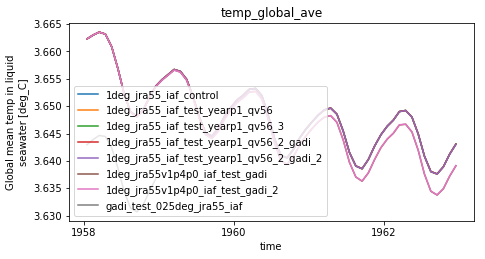

In [16]:
plt.figure(figsize=(16,8))
for i,v in enumerate(variables):
    for ekey in exptdata.exptdict.keys():
        e = exptdata.exptdict[ekey]
        ax = plt.subplot(2,2,i+1)
        e['ocean_scalar.nc'][v].plot(label=e['desc'])
        plt.legend()
        plt.title(v)

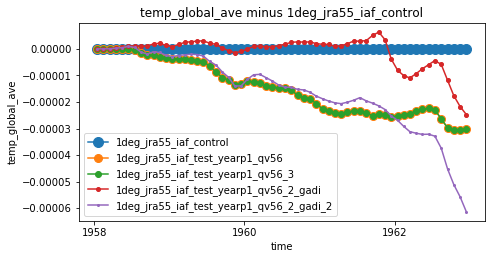

In [17]:
plt.figure(figsize=(16,8))
ref = '1deg_jra55_iaf_control'
# ref = '1deg_jra55_iaf_test_yearp1_qv56'
for i,v in enumerate(variables):
    for j,ekey in enumerate(exptdata.exptdict.keys()):
        if j<5:
            e = exptdata.exptdict[ekey]
            ax = plt.subplot(2,2,i+1)
            data = e['ocean_scalar.nc'][v] - exptdata.exptdict[ref]['ocean_scalar.nc'][v]
            data.plot(label=e['desc'],marker='o', markersize=10-2*j)
            plt.legend()
            plt.title(v+' minus '+ref)

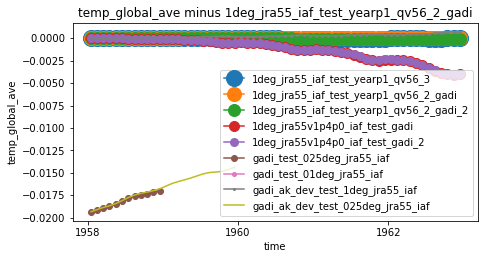

In [19]:
plt.figure(figsize=(16,8))
ref = '1deg_jra55_iaf_test_yearp1_qv56_2_gadi'
# ref = '1deg_jra55_iaf_test_yearp1_qv56'
for i,v in enumerate(variables):
    for j,ekey in enumerate(exptdata.exptdict.keys()):
        if j>1:
            e = exptdata.exptdict[ekey]
            ax = plt.subplot(2,2,i+1)
            data = e['ocean_scalar.nc'][v] - exptdata.exptdict[ref]['ocean_scalar.nc'][v]
            data.plot(label=e['desc'],marker='o', markersize=20-2*j)
            plt.legend()
            plt.title(v+' minus '+ref)

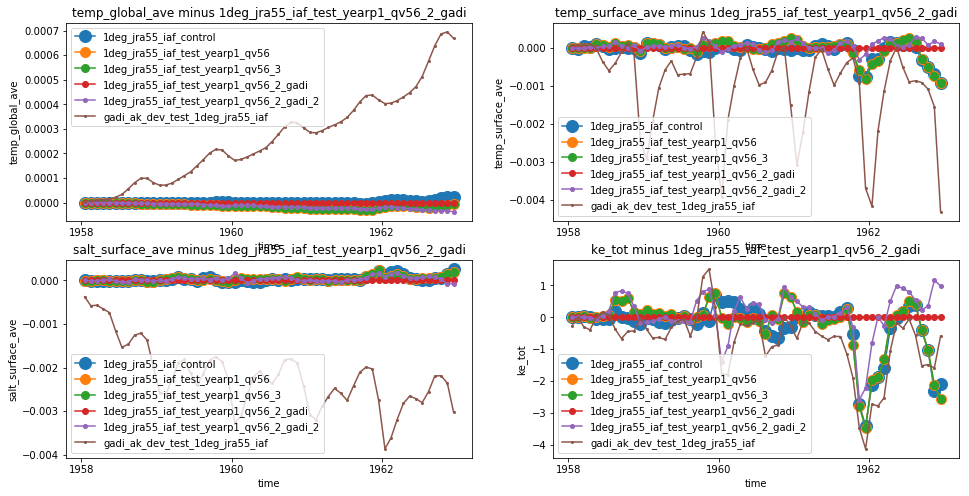

In [32]:
plt.figure(figsize=(16,8))
ref = '1deg_jra55_iaf_test_yearp1_qv56_2_gadi'
# ref = '1deg_jra55_iaf_test_yearp1_qv56'
for i,v in enumerate(variables):
    for j,ekey in enumerate(['1deg_jra55_iaf_control', #'1deg_jra55_iaf_test_yearp1', 
             '1deg_jra55_iaf_test_yearp1_qv56', #'1deg_jra55_iaf_test_yearp1_qv56_2',
             '1deg_jra55_iaf_test_yearp1_qv56_3',
             #'1deg_jra55_iaf_test_yearp1_qv56_2_hybrid',
             '1deg_jra55_iaf_test_yearp1_qv56_2_gadi',
             '1deg_jra55_iaf_test_yearp1_qv56_2_gadi_2',
             #'1deg_jra55v1p4p0_iaf_test_gadi',
             #'1deg_jra55v1p4p0_iaf_test_gadi_2',
             #'gadi_test_025deg_jra55_iaf',
             #'gadi_test_01deg_jra55_iaf',
             'gadi_ak_dev_test_1deg_jra55_iaf',
             #'gadi_ak_dev_test_025deg_jra55_iaf' #,
#              'gadi_ak_dev_test_01deg_jra55_iaf'
            ]):
        e = exptdata.exptdict[ekey]
        ax = plt.subplot(2,2,i+1)
        data = e['ocean_scalar.nc'][v] - exptdata.exptdict[ref]['ocean_scalar.nc'][v]
        data.plot(label=e['desc'],marker='o', markersize=12-2*j)
        plt.legend()
        plt.title(v+' minus '+ref)

In [ ]:
plt.figure(figsize=(16,8))
ref = '1deg_jra55_iaf_test_yearp1_qv56_2_gadi'
# ref = '1deg_jra55_iaf_test_yearp1_qv56'
for i,v in enumerate(variables):
    for j,ekey in enumerate(exptdata.exptdict.keys()):
        if j<5:
            e = exptdata.exptdict[ekey]
            ax = plt.subplot(2,2,i+1)
            data = e['ocean_scalar.nc'][v] - exptdata.exptdict[ref]['ocean_scalar.nc'][v]
            data.plot(label=e['desc'],marker='o', markersize=10-2*j)
            plt.legend()
            plt.title(v+' minus '+ref)

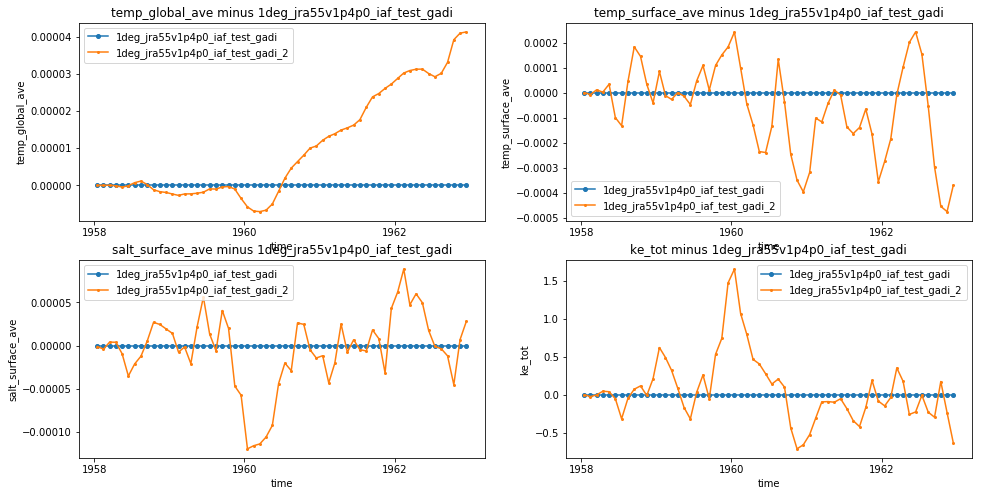

In [43]:
plt.figure(figsize=(16,8))
ref = '1deg_jra55v1p4p0_iaf_test_gadi'
# ref = '1deg_jra55_iaf_test_yearp1_qv56'
for i,v in enumerate(variables):
    for j,ekey in enumerate(exptdata.exptdict.keys()):
        if j>2:
            e = exptdata.exptdict[ekey]
            ax = plt.subplot(2,2,i+1)
            data = e['ocean_scalar.nc'][v] - exptdata.exptdict[ref]['ocean_scalar.nc'][v]
            data.plot(label=e['desc'],marker='o', markersize=10-2*j)
            plt.legend()
            plt.title(v+' minus '+ref)

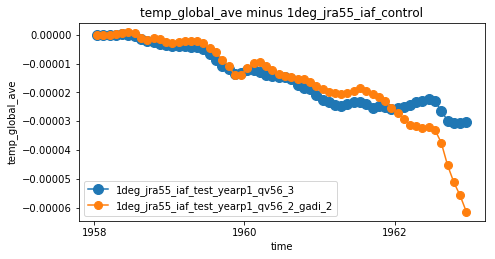

In [15]:
plt.figure(figsize=(16,8))
ref = '1deg_jra55_iaf_test_yearp1_qv56_3'
ref = '1deg_jra55_iaf_control'

for i,v in enumerate(variables):
    for j,ekey in enumerate(['1deg_jra55_iaf_test_yearp1_qv56_3','1deg_jra55_iaf_test_yearp1_qv56_2_gadi_2']):
#         if j>2:
            e = exptdata.exptdict[ekey]
            ax = plt.subplot(2,2,i+1)
            data = e['ocean_scalar.nc'][v] - exptdata.exptdict[ref]['ocean_scalar.nc'][v]
            data.plot(label=e['desc'],marker='o', markersize=10-2*j)
            plt.legend()
            plt.title(v+' minus '+ref)

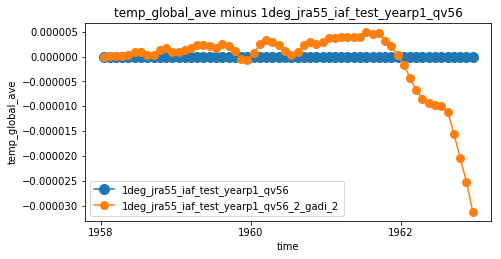

In [18]:
plt.figure(figsize=(16,8))
ref = '1deg_jra55_iaf_test_yearp1_qv56_3'
ref = '1deg_jra55_iaf_test_yearp1_qv56'
# ref = '1deg_jra55_iaf_control'
for i,v in enumerate(variables):
    for j,ekey in enumerate(['1deg_jra55_iaf_test_yearp1_qv56','1deg_jra55_iaf_test_yearp1_qv56_2_gadi_2']):
#         if j>2:
            e = exptdata.exptdict[ekey]
            ax = plt.subplot(2,2,i+1)
            data = e['ocean_scalar.nc'][v] - exptdata.exptdict[ref]['ocean_scalar.nc'][v]
            data.plot(label=e['desc'],marker='o', markersize=10-2*j)
            plt.legend()
            plt.title(v+' minus '+ref)

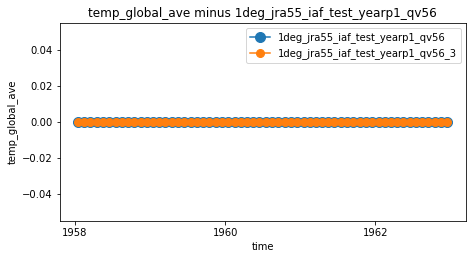

In [24]:
plt.figure(figsize=(16,8))
ref = '1deg_jra55_iaf_test_yearp1_qv56_3'
ref = '1deg_jra55_iaf_test_yearp1_qv56'
# ref = '1deg_jra55_iaf_control'
for i,v in enumerate(variables):
    for j,ekey in enumerate(['1deg_jra55_iaf_test_yearp1_qv56','1deg_jra55_iaf_test_yearp1_qv56_3']):
#         if j>2:
            e = exptdata.exptdict[ekey]
            ax = plt.subplot(2,2,i+1)
            data = e['ocean_scalar.nc'][v] - exptdata.exptdict[ref]['ocean_scalar.nc'][v]
            data.plot(label=e['desc'],marker='o', markersize=10-2*j)
            plt.legend()
            plt.title(v+' minus '+ref)

## checking surface fields at final time

In [18]:
# variables2d = ['pme_river', 'river', 'evap', 'sfc_salt_flux_coupler', 'net_sfc_heating', 'tau_x', 'tau_y']
variables2d = ['pme_river']
# variables2d = ['pme_river', 'river']
for v in variables2d:
    load_data(v,'ocean_month.nc')

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


max abs pme_river 1deg_jra55_iaf_control minus 1deg_jra55_iaf_control = 0.0
max abs pme_river 1deg_jra55_iaf_test_yearp1_qv56 minus 1deg_jra55_iaf_control = 2.019004e-05
max abs pme_river 1deg_jra55_iaf_test_yearp1_qv56_2_gadi minus 1deg_jra55_iaf_control = 3.676006e-05
max abs pme_river 1deg_jra55v1p4p0_iaf_test_gadi minus 1deg_jra55_iaf_control = 3.676006e-05


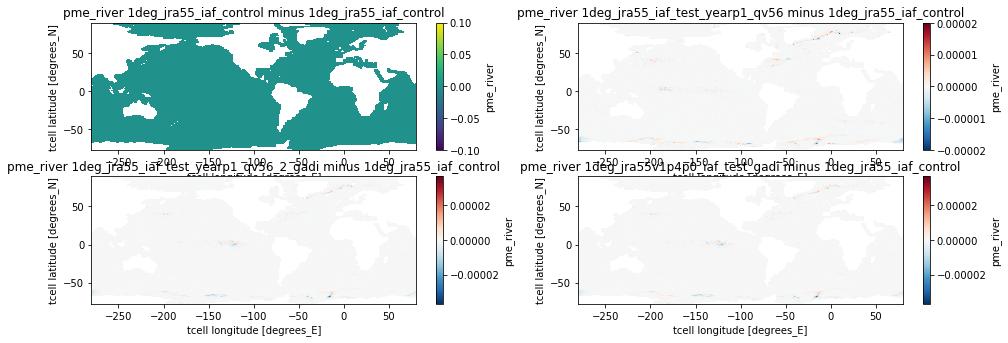

In [20]:
ref = '1deg_jra55_iaf_control'
# ref = '1deg_jra55_iaf_test_yearp1_qv56_2_gadi'
r = exptdata.exptdict[ref]['ocean_month.nc']
# ref = '1deg_jra55_iaf_test_yearp1_qv56'
for i,v in enumerate(r):
    plt.figure(figsize=(16,8))
    for j,ekey in enumerate(exptdata.exptdict.keys()):
        e = exptdata.exptdict[ekey]['ocean_month.nc']
#         ax = plt.subplot(1+(len(r)*len(exptdata.exptdict))//2,2,i*(j+1)+j+1)
        ax = plt.subplot(1+len(exptdata.exptdict)//2,2,j+1)
        data = e[v].isel(time=-1) \
             - r[v].isel(time=-1)
        data.plot()
        plt.title(v+' '+ekey+' minus '+ref)
        print('max abs '+v+' '+ekey+' minus '+ref+' = '+str(np.fabs(data).max().values))